In [1]:
pip install findspark pandas awswrangler numpy matplotlib seaborn pyspark


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
import pandas as pd
import awswrangler as wr
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import matplotlib.ticker as ticker
import boto3
import statistics

Average: 0.4458072957551685
Mode: 2.0
Median: 0.43479880604361065


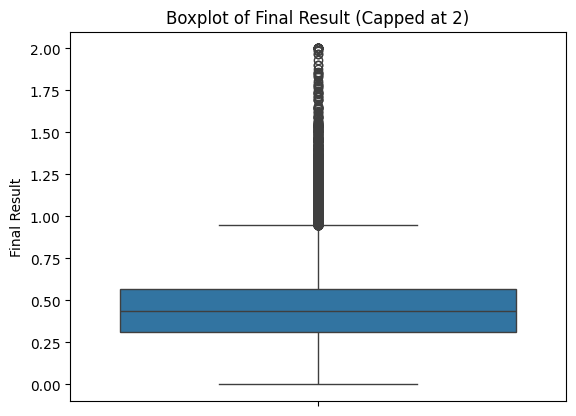

In [ ]:
findspark.init()
# Read Parquet file from S3 using AWS Wrangler
df = pd.read_parquet('../../../generate data/datasets/general/')
df = df[df["partCodeId"].str.len() > 10]
df["partCodeId"] = df["partCodeId"].str[:11]
df["formula_result"] = (df["dfQuantity"] - df["actualQuantity"]).abs() / df["actualQuantity"]
# Group by the correct columns
df_result = df.groupby([
    "partCodeId",
    "vehicleModelId",
    "forecastDistance"
]).agg(
    final_result=("formula_result", "mean"),
).reset_index()

# Remove values that are below 0
df_result = df_result[df_result["final_result"] >= 0]

# Cap the final_result values at 2
df_result["final_result_capped"] = df_result["final_result"].clip(upper=2)


# Calculate statistics
average = df_result["final_result_capped"].mean()
mode = df_result["final_result_capped"].mode()[0]
median = df_result["final_result_capped"].median()

print(f"Average: {average}")
print(f"Mode: {mode}")
print(f"Median: {median}")

# Plot the data using seaborn
seaborn.boxplot(y=df_result["final_result_capped"])
plt.title("Boxplot of Final Result (Capped at 2)")
plt.ylabel("Final Result")
plt.show()

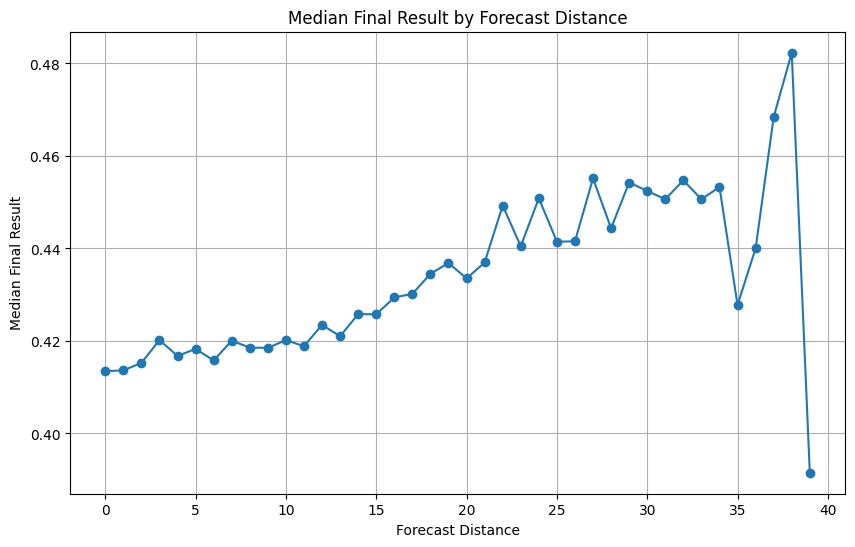

In [4]:
# Group by forecastdistance and calculate the median for each group
df_forecast_distance_median = df_result.groupby("forecastDistance")["final_result_capped"].median().reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_forecast_distance_median["forecastDistance"], df_forecast_distance_median["final_result_capped"], marker='o')
plt.xlabel("Forecast Distance")
plt.ylabel("Median Final Result")
plt.title("Median Final Result by Forecast Distance")
plt.grid(True)
plt.show()

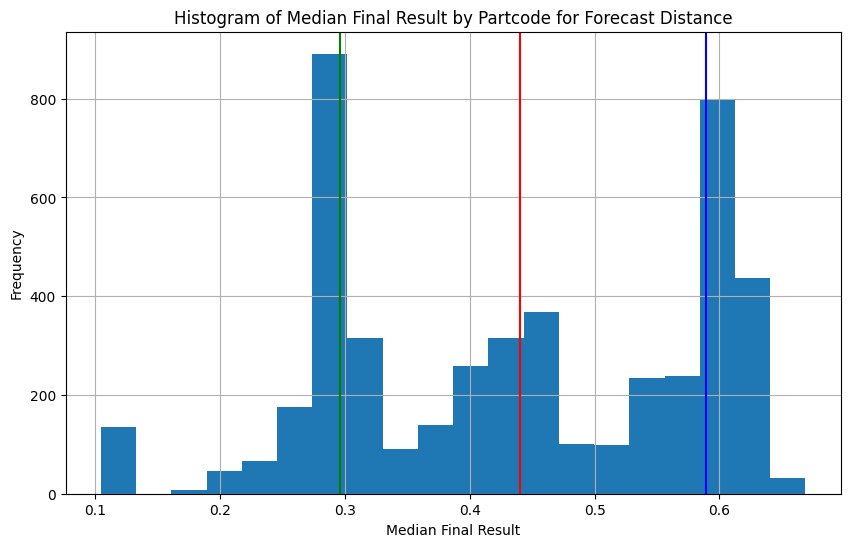

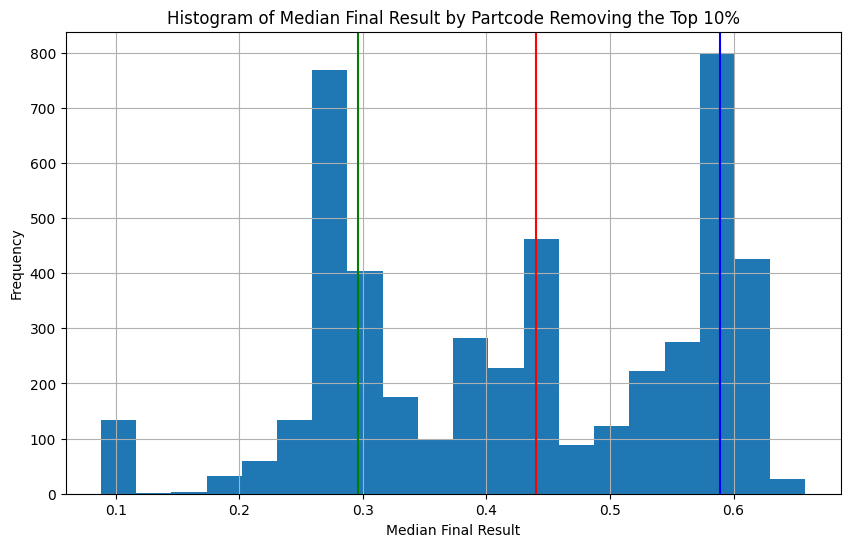

In [5]:
# Function to remove the top 10% of the highest values and calculate the median
def remove_top_10_percent_and_median(group):
    # Calculate the number of values to remove
    n = int(len(group) * 0.1)
    # Remove the top 10% of the highest values
    group = group.nsmallest(len(group) - n)
    # Return the median of the remaining values
    return group.median()

#group by partcode and calculate the median for each partcode
df_partcode_median = df_result.groupby("partCodeId")["final_result_capped"].median().reset_index()
plt.figure(figsize=(10, 6))
plt.hist(df_partcode_median["final_result_capped"], bins=20)
plt.axvline(df_partcode_median["final_result_capped"].quantile(0.25), color='g')
plt.axvline(df_partcode_median["final_result_capped"].quantile(0.5), color='r')
plt.axvline(df_partcode_median["final_result_capped"].quantile(0.75), color='b')
plt.xlabel("Median Final Result")
plt.ylabel("Frequency")
plt.title("Histogram of Median Final Result by Partcode for Forecast Distance")
plt.grid(True)
plt.show()

#group by partcode, remove the 10% of the highest values and calculate the median for each partcode
df_partcode_median_without_top_values = df_result.groupby("partCodeId")["final_result_capped"].apply(remove_top_10_percent_and_median).reset_index()
#print the df_partcode_median in a histogram
plt.figure(figsize=(10, 6))
plt.hist(df_partcode_median_without_top_values["final_result_capped"], bins=20)
plt.axvline(df_partcode_median["final_result_capped"].quantile(0.25), color='g')
plt.axvline(df_partcode_median["final_result_capped"].quantile(0.5), color='r')
plt.axvline(df_partcode_median["final_result_capped"].quantile(0.75), color='b')
plt.xlabel("Median Final Result")
plt.ylabel("Frequency")
plt.title("Histogram of Median Final Result by Partcode Removing the Top 10%")
plt.grid(True)
plt.show()



